In [1]:
import tensorflow

import pandas as pd
import numpy as np #데이터 배열화
import os #경로 설정용 
import keras #딥러닝용 패키지
import random #데이터 분산할 때 쓸 랜덤
import cv2 #이미지 읽기용
import math #연산용
import seaborn as sns #matplotlib에 다양한 시각화 기능이 추가된 패키지

from sklearn.metrics import confusion_matrix #분류의 정확성 평가
from sklearn.preprocessing import LabelBinarizer #데이터 전처리용
from sklearn.model_selection import train_test_split #데이터 분할용

import matplotlib.pyplot as plt #데이터 시각화용

from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,Convolution2D,BatchNormalization #사용할 BN, ConV2 등의 계층
from tensorflow.keras.layers import Flatten,MaxPooling2D,Dropout, Input #사용할 레이어
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.applications import EfficientNetB7

from tensorflow.keras.preprocessing import image #이미지 데이터를 실시간으로 처리하기 위한 도구
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array #이미지 편집을 위한 제너레이터(Affine Transform)

from tensorflow.keras.models import Model #교육 및 추론 기능이 있는 개체로 레이어를 그룹화

from tensorflow.keras.optimizers import Adam #Adam 옵티마이저 사용. loss는 categorical_crossentropy 사용

#체크포인트를 두고 저장 + metric이 중지되면 학습률을 감소
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau 

import warnings #경고 무시
warnings.filterwarnings("ignore")

In [2]:
data=[]
labels=[]
random.seed(42)
imagePaths = sorted(list(os.listdir("emotion_FixedVer/")))
random.shuffle(imagePaths)
print(imagePaths)

for img in imagePaths:
    path=sorted(list(os.listdir("emotion_FixedVer/"+img)))
    for i in path:
        image = cv2.imread("emotion_FixedVer/"+img+'/'+i)
        image = cv2.resize(image, (48,48))
        image = img_to_array(image)
        data.append(image)
        l = label = img
        labels.append(l)

['neutral', 'fearful', 'happy', 'sad', 'angry', 'surprised']


In [3]:
data = np.array(data, dtype="float32") / 255.0
labels = np.array(labels)
mlb = LabelBinarizer()
labels = mlb.fit_transform(labels)
print(labels[0])

[0 0 0 1 0 0]


In [4]:
(xtrain,xtest,ytrain,ytest)=train_test_split(data,labels,test_size=0.2,random_state=42)
print(xtrain.shape, xtest.shape)

(22294, 48, 48, 3) (5574, 48, 48, 3)


In [5]:
datagen = ImageDataGenerator(zoom_range = 0.2, horizontal_flip=True, shear_range=0.2) #이미지 가공(학습률 향상을 위한 augmentation)
datagen.fit(xtrain)

In [6]:
model = EfficientNetB7(include_top=False, input_shape=(48, 48, 3), weights="imagenet")
# Freeze the pretrained weights
model.trainable = False

# Rebuild top
x = GlobalAveragePooling2D(name="avg_pool")(model.output)
x = BatchNormalization()(x)

top_dropout_rate = 0.2
x = Dropout(top_dropout_rate, name="top_dropout")(x)
outputs = Dense(6, activation="softmax", name="pred")(x)
    
model=Model(model.input,outputs)

In [7]:
model.compile(
    optimizer = Adam(lr=0.001), 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
  )

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 48, 48, 3)]  0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 48, 48, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 48, 48, 3)    7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 49, 49, 3)    0           normalization[0][0]              
______________________________________________________________________________________________

block7d_bn (BatchNormalization) (None, 2, 2, 3840)   15360       block7d_dwconv[0][0]             
__________________________________________________________________________________________________
block7d_activation (Activation) (None, 2, 2, 3840)   0           block7d_bn[0][0]                 
__________________________________________________________________________________________________
block7d_se_squeeze (GlobalAvera (None, 3840)         0           block7d_activation[0][0]         
__________________________________________________________________________________________________
block7d_se_reshape (Reshape)    (None, 1, 1, 3840)   0           block7d_se_squeeze[0][0]         
__________________________________________________________________________________________________
block7d_se_reduce (Conv2D)      (None, 1, 1, 160)    614560      block7d_se_reshape[0][0]         
__________________________________________________________________________________________________
block7d_se

In [9]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

In [8]:
epochs = 20  # @param {type: "slider", min:8, max:80}
hist = model.fit(datagen.flow(xtrain, ytrain, batch_size=32), epochs=epochs, validation_data=(xtest, ytest), verbose=2)
plot_hist(hist)

Epoch 1/20
697/697 - 99s - loss: 1.9252 - accuracy: 0.2086 - val_loss: 1.7742 - val_accuracy: 0.1742
Epoch 2/20
697/697 - 75s - loss: 1.9033 - accuracy: 0.2051 - val_loss: 1.7614 - val_accuracy: 0.2614
Epoch 3/20
697/697 - 76s - loss: 1.8948 - accuracy: 0.2095 - val_loss: 1.7648 - val_accuracy: 0.2614
Epoch 4/20
697/697 - 75s - loss: 1.8865 - accuracy: 0.2130 - val_loss: 1.7641 - val_accuracy: 0.2614
Epoch 5/20
697/697 - 76s - loss: 1.8744 - accuracy: 0.2101 - val_loss: 1.7875 - val_accuracy: 0.2614
Epoch 6/20
697/697 - 76s - loss: 1.8693 - accuracy: 0.2146 - val_loss: 1.7796 - val_accuracy: 0.2614
Epoch 7/20
697/697 - 76s - loss: 1.8607 - accuracy: 0.2198 - val_loss: 1.7544 - val_accuracy: 0.2614
Epoch 8/20
697/697 - 76s - loss: 1.8539 - accuracy: 0.2171 - val_loss: 1.7734 - val_accuracy: 0.2614
Epoch 9/20
697/697 - 80s - loss: 1.8582 - accuracy: 0.2148 - val_loss: 1.7750 - val_accuracy: 0.2614
Epoch 10/20
697/697 - 79s - loss: 1.8413 - accuracy: 0.2207 - val_loss: 1.7660 - val_accura

NameError: name 'plot_hist' is not defined

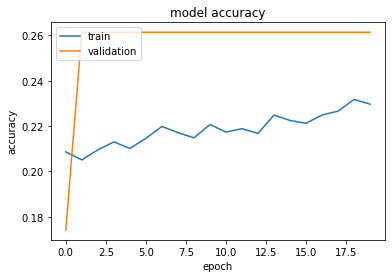

In [10]:
plot_hist(hist)

In [11]:
model.evaluate(xtest, ytest, batch_size = 32)

175/175 [==============================] - 15s 83ms/step - loss: 1.7581 - accuracy: 0.2614


[1.7581182718276978, 0.26139217615127563]

In [ ]:
model.save('EfficientNet_keras_emotion6ver_imsize48__lr0.01_epoch100.h5')

In [ ]:
#완성도 확인
ypred = model.predict(xtest)

total = 0
accurate = 0
accurateindex = []
wrongindex = []

for i in range(len(ypred)):
    if np.argmax(ypred[i]) == np.argmax(ytest[i]): #가장 큰 값을 찾아 인덱스 반환
        accurate += 1
        accurateindex.append(i)
    else:
        wrongindex.append(i)
        
    total += 1
    
print('Total-test-data;', total, '\taccurately-predicted-data:', accurate, '\t wrongly-predicted-data: ', total - accurate)
print('Accuracy:', round(accurate/total*100, 3), '%')

## 2차 훈련

In [14]:
def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-20:]:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = True

    optimizer = Adam(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )


In [15]:
unfreeze_model(model)

Epoch 1/10
697/697 - 96s - loss: 1.7977 - accuracy: 0.2328 - val_loss: 1.8069 - val_accuracy: 0.1742
Epoch 2/10
697/697 - 73s - loss: 1.7844 - accuracy: 0.2362 - val_loss: 1.7663 - val_accuracy: 0.2614
Epoch 3/10
697/697 - 75s - loss: 1.7803 - accuracy: 0.2374 - val_loss: 1.8122 - val_accuracy: 0.2614
Epoch 4/10
697/697 - 74s - loss: 1.7795 - accuracy: 0.2418 - val_loss: 1.8096 - val_accuracy: 0.1383
Epoch 5/10
697/697 - 72s - loss: 1.7769 - accuracy: 0.2443 - val_loss: 1.8424 - val_accuracy: 0.1746
Epoch 6/10
697/697 - 72s - loss: 1.7751 - accuracy: 0.2446 - val_loss: 1.8090 - val_accuracy: 0.1722
Epoch 7/10
697/697 - 74s - loss: 1.7743 - accuracy: 0.2434 - val_loss: 1.8213 - val_accuracy: 0.2614
Epoch 8/10
697/697 - 73s - loss: 1.7729 - accuracy: 0.2464 - val_loss: 1.8040 - val_accuracy: 0.2614
Epoch 9/10
697/697 - 73s - loss: 1.7701 - accuracy: 0.2460 - val_loss: 1.8833 - val_accuracy: 0.2614
Epoch 10/10
697/697 - 72s - loss: 1.7716 - accuracy: 0.2480 - val_loss: 1.8175 - val_accura

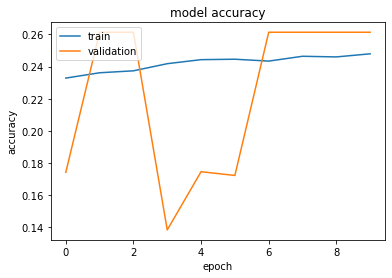

In [16]:
epochs = 10  # @param {type: "slider", min:8, max:50}
hist = model.fit(datagen.flow(xtrain, ytrain, batch_size=32), epochs=epochs, validation_data=(xtest, ytest), verbose=2)
plot_hist(hist)

Total-test-data; 5574 	accurately-predicted-data: 1457 	 wrongly-predicted-data:  4117
Accuracy: 26.139 %
